<a href="https://colab.research.google.com/github/denizbariscan/DSA210-Term-Project/blob/main/data%20processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

This block imports essential libraries for data analysis and visualization, and mounts Google Drive to access external data files.

In [13]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
import numpy as np
from datetime import datetime
import re
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**FORMING THE COMPARISON TABLE**

This block performs comprehensive cleaning and transformation of raw sales data from two branches (Hilltown and Balçova) and prepares a comparative product performance table.

Steps:

Read Excel Files: Import raw product sales data from both branches.

Standardize Column & Product Names: Strip whitespaces, convert to lowercase, remove leading underscores.

Handle Missing Data: Replace empty strings with NaN, remove rows with missing or non-numeric revenue.

Drop Duplicates & Invalid Records: Remove duplicate entries and rows with zero or negative revenue.

Identify Common Products: Filter out products sold in both branches.

Aggregate Metrics: Calculate total revenue and quantity sold per product for each branch.

Calculate Averages & Differences:

Compute average price per product.

Calculate price and quantity differences between branches.

Organize the Final Table:

Select and order relevant columns.

Sort by Hilltown sales volume.

Round monetary values to the nearest integer.

Export Results: Save the final comparison table as an Excel file.

This cleaned and structured dataset enables further statistical analysis, price-performance evaluation, and strategic insights for product performance across branches.

In [14]:
#Data Cleaning
htfile = '/content/drive/MyDrive/dsa/Hilltown Ürün Çıkış Raporu 8 Ekim - 10 Nisan.xlsx'
balcovafile = "/content/drive/MyDrive/dsa/urun-cikis-raporu-1744210116 (1).xlsx"
hilltown_df = pd.read_excel(htfile)
balcova_df = pd.read_excel(balcovafile)

# 1.Clean the spaces in column names
hilltown_df.columns = hilltown_df.columns.str.strip()
balcova_df.columns = balcova_df.columns.str.strip()
# 2.Normalize product names: turn to lower case, clean spaces and "_" at the beginning
hilltown_df["Ürün Adı"] = hilltown_df["Ürün Adı"].astype(str).str.strip().str.lower().str.lstrip("_")
balcova_df["Ürün Adı"] = balcova_df["Ürün Adı"].astype(str).str.strip().str.lower().str.lstrip("_")
# 3.Make empty strings NaN
hilltown_df.replace("", np.nan, inplace=True)
balcova_df.replace("", np.nan, inplace=True)
# 4.Eksik Tutar verilerini çıkar
hilltown_df = hilltown_df.dropna(subset=["Tutar"])
balcova_df = balcova_df.dropna(subset=["Tutar"])
# 5.Turn "Tutar" columns to numeric
hilltown_df["Tutar"] = pd.to_numeric(hilltown_df["Tutar"], errors="coerce")
balcova_df["Tutar"] = pd.to_numeric(balcova_df["Tutar"], errors="coerce")
# 6.Delete repeated rows
hilltown_df = hilltown_df.drop_duplicates()
balcova_df = balcova_df.drop_duplicates()
# 7.Remove 0 and negatives
hilltown_df = hilltown_df[hilltown_df["Tutar"] > 0]
balcova_df = balcova_df[balcova_df["Tutar"] > 0]
#Find common products
common_products = set(hilltown_df["Ürün Adı"]).intersection(set(balcova_df["Ürün Adı"]))
ht_common = hilltown_df[hilltown_df["Ürün Adı"].isin(common_products)].copy()
bal_common = balcova_df[balcova_df["Ürün Adı"].isin(common_products)].copy()

ht_summary = ht_common.groupby("Ürün Adı").agg({
    "Tutar": "sum",
    "Adet": "sum"
}).rename(columns={"Tutar": "Hilltown Toplam Tutar", "Adet": "Hilltown Satış Miktarı"})

bal_summary = bal_common.groupby("Ürün Adı").agg({
    "Tutar": "sum",
    "Adet": "sum"
}).rename(columns={"Tutar": "Balçova Toplam Tutar", "Adet": "Balçova Satış Miktarı"})
#Merge
merged_sales = pd.merge(ht_summary, bal_summary, left_index=True, right_index=True)

#Calculate average
merged_sales["Hilltown Ortalama Fiyat"] = merged_sales["Hilltown Toplam Tutar"] / merged_sales["Hilltown Satış Miktarı"]
merged_sales["Balçova Ortalama Fiyat"] = merged_sales["Balçova Toplam Tutar"] / merged_sales["Balçova Satış Miktarı"]
#Take the difference
merged_sales["Fiyat Farkı (Hilltown - Balçova)"] = merged_sales["Hilltown Ortalama Fiyat"] - merged_sales["Balçova Ortalama Fiyat"]
merged_sales["Satış Miktarı Farkı (Hilltown - Balçova)"] = merged_sales["Hilltown Satış Miktarı"] - merged_sales["Balçova Satış Miktarı"]
#Organize the table
final_table = merged_sales.reset_index()[[
    "Ürün Adı",
    "Hilltown Ortalama Fiyat",
    "Balçova Ortalama Fiyat",
    "Fiyat Farkı (Hilltown - Balçova)",
    "Hilltown Satış Miktarı",
    "Balçova Satış Miktarı",
    "Satış Miktarı Farkı (Hilltown - Balçova)"
]]
#Order in descending based on total sales quantity
final_table = final_table.sort_values(by="Hilltown Satış Miktarı", ascending=False).reset_index(drop=True)
#Roll numbers to closest integer
cols_to_round = ["Hilltown Ortalama Fiyat", "Balçova Ortalama Fiyat", "Fiyat Farkı (Hilltown - Balçova)"]
final_table[cols_to_round] = final_table[cols_to_round].round(0).astype("Int64")
output_path = "/content/drive/MyDrive/dsa/karşılaştırma tablosu.xlsx"
final_table.to_excel(output_path, index=False)
final_table.head(20)


,Ürün Adı,Hilltown Ortalama Fiyat,Balçova Ortalama Fiyat,Fiyat Farkı (Hilltown - Balçova),Hilltown Satış Miktarı,Balçova Satış Miktarı,Satış Miktarı Farkı (Hilltown - Balçova)
0,coca cola - şişe,66,57,8,14583,1639,12944
1,ohannes cheese burger,313,303,10,6590,3287,3303
2,ayran kutu,54,42,12,5314,1256,4058
3,regular cheese burger,279,119,160,4435,1865,2570
4,regular classic burger,197,71,126,4202,2245,1957
5,su - şişe,37,30,7,3741,472,3269
6,ohannes classic burger,250,280,-30,3687,1347,2340
7,carlsberg 50 ml,190,120,70,3419,411,3008
8,coca cola zero - şişe,68,58,10,3305,684,2621
9,ohannes mushroom burger,315,298,17,3159,1794,1365


**FORMING A DAILY REVENUE TABLE FOR HILLTOWN BRANCH**

This block manually creates a monthly revenue table for the Hilltown branch and calculates the average daily revenue for each month.

Steps:

Define Monthly Revenue Data: A list of dictionaries contains total revenue and number of operational days for each month.

Convert to DataFrame: The list is transformed into a structured pandas DataFrame.

Calculate Daily Average: For each month, average daily revenue is computed by dividing total revenue by the number of days.

Export to Excel: The final table is saved as an Excel file for further use or analysis.

This provides a clean and ready-to-use dataset for visualizing trends, comparing with other branches, or performing correlation analysis.

In [15]:
#Make a table of Daily Revenue values of the Hilltown branch
data = [
    {"Month": "October", "Total Revenue": 3_237_584.80, "Number of Days": 31},
    {"Month": "November", "Total Revenue": 3_228_013.60, "Number of Days": 30},
    {"Month": "December", "Total Revenue": 3_296_657.73, "Number of Days": 31},
    {"Month": "January", "Total Revenue": 3_495_294.48, "Number of Days": 31},
    {"Month": "February", "Total Revenue": 2_725_767.42, "Number of Days": 28},
    {"Month": "March", "Total Revenue": 3_464_407.50, "Number of Days": 31},
    {"Month": "April", "Total Revenue": 3_211_515.63, "Number of Days": 24}
]
df = pd.DataFrame(data)

#Calculate the average daily revenue and add as a new column
df["Average Daily Revenue"] = (df["Total Revenue"] / df["Number of Days"]).round(2)
df.to_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx", index=False)
print(df)


      Month  Total Revenue  Number of Days  Average Daily Revenue
0   October     3237584.80              31              104438.22
1  November     3228013.60              30              107600.45
2  December     3296657.73              31              106343.80
3   January     3495294.48              31              112751.43
4  February     2725767.42              28               97348.84
5     March     3464407.50              31              111755.08
6     April     3211515.63              24              133813.15


**FORMING A DAILY REVENUE TABLE FOR BALÇOVA BRANCH**

This block manually constructs a monthly revenue table for the Balçova branch and calculates the average daily revenue per month.

Steps:

Define Monthly Revenue Data: A list of dictionaries includes total monthly revenue and the corresponding number of active sales days.

Create DataFrame: The list is converted into a structured pandas DataFrame.

Compute Daily Revenue: Average daily revenue is calculated by dividing the total revenue by the number of days in each month.

Export to Excel: The final dataset is saved as an Excel file for further analysis or visualization.

This table can be used for time series analysis, branch performance comparison, or weather/school break correlations.

In [17]:
#Make a table of Daily Revenue values of the Balçova branch
data = [
    {"Month": "October", "Total Revenue": 848_267.60, "Number of Days": 31},
    {"Month": "November", "Total Revenue": 1_258_737.80, "Number of Days": 30},
    {"Month": "December", "Total Revenue": 1_565_782.00, "Number of Days": 31},
    {"Month": "January", "Total Revenue": 1_831_322.35, "Number of Days": 31},
    {"Month": "February", "Total Revenue": 1_675_118.05, "Number of Days": 28},
    {"Month": "March", "Total Revenue": 2_157_938.25, "Number of Days": 31},
    {"Month": "April", "Total Revenue": 1_918_506.87, "Number of Days": 22}
]
df = pd.DataFrame(data)

#Calculate the average daily revenue and add as a new column
df["Average Daily Revenue"] = (df["Total Revenue"] / df["Number of Days"]).round(2)
df.to_excel("/content/drive/MyDrive/dsa/balcova daily revenue.xlsx", index=False)
print(df)


      Month  Total Revenue  Number of Days  Average Daily Revenue
0   October      848267.60              31               27363.47
1  November     1258737.80              30               41957.93
2  December     1565782.00              31               50509.10
3   January     1831322.35              31               59074.91
4  February     1675118.05              28               59825.64
5     March     2157938.25              31               69610.91
6     April     1918506.87              22               87204.86


**MERGING DATAS**

This block analyzes the relationship between school vacation days and Hilltown branch’s average daily revenue using Pearson correlation.

Steps:

Read Data: Import Hilltown’s average daily revenue data from Excel.

Format Months: Map short month names to full date labels for alignment.

Define Vacation Data: Create a DataFrame with monthly school vacation days.

Merge Datasets: Combine revenue and vacation data by matching month.

Calculate Correlation: Use Pearson's r to measure the strength and direction of the relationship.

Visualize: Display a scatter plot with regression line and correlation result in the title.

This plot helps assess whether school breaks impact Hilltown's daily revenue.

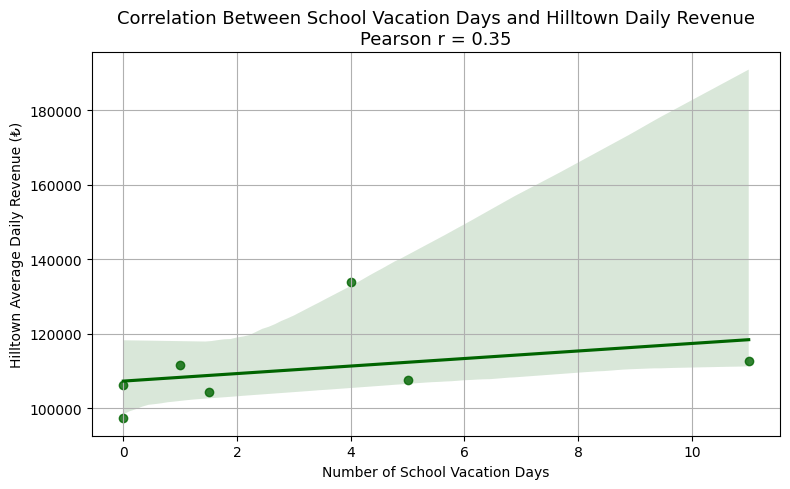

In [11]:
# 1. Read Hilltown revenue data directly from file
hilltown_df_clean = pd.read_excel("/content/drive/MyDrive/dsa/hiltown daily revenue.xlsx").copy()
# 2. Map months to full datetime format
month_map = {
    "October": "October 2024", "November": "November 2024", "December": "December 2024",
    "January": "January 2025", "February": "February 2025", "March": "March 2025", "April": "April 2025"
}
hilltown_df_clean["Month"] = hilltown_df_clean["Month"].map(month_map)
# 3. School vacation data
df_holidays = pd.DataFrame({
    "Month": ["October 2024", "November 2024", "December 2024",
              "January 2025", "February 2025", "March 2025", "April 2025"],
    "School Vacation Days": [1.5, 5, 0, 11, 0, 1, 4]
})
# 4. Merge datasets
merged_holiday_df = pd.merge(df_holidays, hilltown_df_clean[["Month", "Average Daily Revenue"]], on="Month")
correlation, p_value = pearsonr(merged_holiday_df["School Vacation Days"], merged_holiday_df["Average Daily Revenue"])
plt.figure(figsize=(8, 5))
sns.regplot(x="School Vacation Days", y="Average Daily Revenue", data=merged_holiday_df, color="darkgreen")
plt.title(f"Correlation Between School Vacation Days and Hilltown Daily Revenue\nPearson r = {correlation:.2f}", fontsize=13)
plt.xlabel("Number of School Vacation Days")
plt.ylabel("Hilltown Average Daily Revenue (₺)")
plt.grid(True)
plt.tight_layout()
plt.show()


**CALCULATING PEARSON CORRELATION**

This block performs data cleaning, calculates the Pearson correlation between price differences and sales differences between two branches, and visualizes the results.

Steps:

Read Data from Excel: Load the dataset from an Excel file containing price and sales differences between Hilltown and Balçova branches.

Data Cleaning: Remove rows where there are NaN values in the Fiyat Farkı (Hilltown - Balçova) and Satış Miktarı Farkı (Hilltown - Balçova) columns.

Extract Columns: Isolate the relevant columns — price difference and sales difference.

Calculate Pearson Correlation: Perform the Pearson correlation test between the price and sales differences, and calculate the correlation coefficient and p-value.

Hypothesis Testing: Test the null hypothesis (H₀) that there is no significant relationship between price and sales differences.

Visualize the Data: Create a scatter plot of the price vs sales differences and show the correlation coefficient and p-value in the title.

Pearson Correlation Test Results
-----------------------------------
Correlation coefficient: -0.0952
p-value: 0.2773
Fail to Reject H₀: There is no significant relationship between the price difference and sales quantity between the two branches.


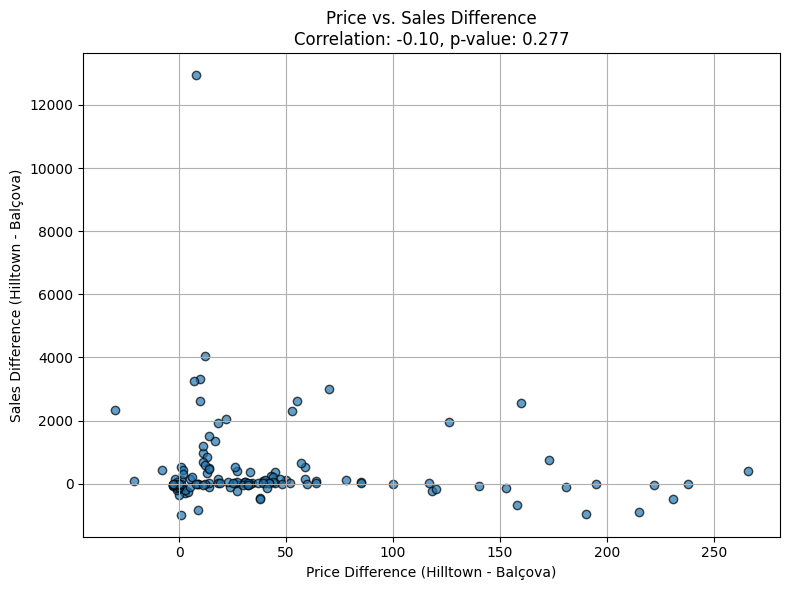

In [12]:
file_path = "/content/drive/MyDrive/dsa/karşılaştırma tablosu.xlsx"
df = pd.read_excel(file_path)

# 2. Clean NaN rows
df_clean = df.dropna(subset=["Fiyat Farkı (Hilltown - Balçova)", "Satış Miktarı Farkı (Hilltown - Balçova)"])

# 3. Choose the important columns
price_diff = df_clean["Fiyat Farkı (Hilltown - Balçova)"]
sales_diff = df_clean["Satış Miktarı Farkı (Hilltown - Balçova)"]
correlation, p_value = pearsonr(price_diff, sales_diff)
print("Pearson Correlation Test Results")
print("-----------------------------------")
print(f"Correlation coefficient: {correlation:.4f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("Reject H₀: There is a significant relationship between the price difference and sales quantity between the two branches.")
else:
    print("Fail to Reject H₀: There is no significant relationship between the price difference and sales quantity between the two branches.")

# 7. Grafik
plt.figure(figsize=(8, 6))
plt.scatter(price_diff, sales_diff, alpha=0.7, edgecolors='k')
plt.title(f'Price vs. Sales Difference\nCorrelation: {correlation:.2f}, p-value: {p_value:.3f}')
plt.xlabel('Price Difference (Hilltown - Balçova)')
plt.ylabel('Sales Difference (Hilltown - Balçova)')
plt.grid(True)
plt.tight_layout()
plt.show()
